In [1]:
import os
os.environ["KAGGLEHUB_CACHE"]="/content/data"

In [2]:
import kagglehub

# Download dataset
path = kagglehub.dataset_download("alxmamaev/flowers-recognition")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/flowers-recognition


In [3]:
from torch.utils.data import Dataset
from PIL import Image
import glob
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torch.nn as nn
import torch
import os

##since the dataset is organized in subfolders I'm going to use ImageFolder

In [4]:
# Definining transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])


# Loading the dataset
dataset = ImageFolder(root=os.path.join(path,"flowers"), transform=transform)
class_names=dataset.classes
print("Number of images:", len(dataset))
print("Classes:", class_names)   # ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
print("Class to index mapping:", dataset.class_to_idx)


Number of images: 4317
Classes: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
Class to index mapping: {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}


##Split into train & test  using random_split

In [5]:
from torch.utils.data import random_split,DataLoader
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
BATCH_SIZE = 32
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [6]:
# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7c1982737080>, <torch.utils.data.dataloader.DataLoader object at 0x7c1a72c1ae40>)
Length of train dataloader: 108 batches of 32
Length of test dataloader: 27 batches of 32


In [7]:
# Checking out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

##Using Pretrained ResNet18 for Flower Classification with Transfer Learning


In [8]:
from torchvision.models import resnet18

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = resnet18(pretrained=True)
next(model.parameters()).device

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 72.3MB/s]


device(type='cpu')

In [9]:
#printing the model
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
#Listing the layers
for name, layer in model.named_children():
    print(name, layer)

conv1 Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
bn1 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
relu ReLU(inplace=True)
maxpool MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
layer1 Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1

In [11]:
#Transfer Learning
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 5)  # because we have 5 flower classes

In [12]:
# Freezing all layers except the last one
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True


In [13]:
model=model.to(device)

In [14]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

##training and testing functions

In [15]:
def train_step(model, dataloader, loss_fn, optimizer, device):
    model.train()
    total_loss, total_acc = 0, 0

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        # Forward
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        total_loss += loss.item()

        # Accuracy
        preds = torch.argmax(y_pred, 1)
        total_acc += (preds == y).sum().item()

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(dataloader)
    avg_acc = total_acc / (len(dataloader.dataset))
    return avg_loss, avg_acc


def test_step(model, dataloader, loss_fn, device):
    model.eval()
    total_loss, total_acc = 0, 0

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            total_loss += loss.item()

            preds = torch.argmax(y_pred, 1)
            total_acc += (preds == y).sum().item()

    avg_loss = total_loss / len(dataloader)
    avg_acc = total_acc / (len(dataloader.dataset))
    return avg_loss, avg_acc

## Evaluation function

In [16]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device: torch.device = device):

    model.eval()
    total_loss = 0
    total_correct = 0

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)

            # Loss
            loss = loss_fn(y_pred, y)
            total_loss += loss.item()

            # Accuracy
            preds = y_pred.argmax(dim=1)
            total_correct += (preds == y).sum().item()

    avg_loss = total_loss / len(data_loader)
    avg_acc = total_correct / len(data_loader.dataset)

    return {
        "model_name": model.__class__.__name__,
        "model_loss": avg_loss,
        "model_acc": avg_acc
    }

In [17]:
epochs = 12

from tqdm import tqdm

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)
    test_loss, test_acc = test_step(model, test_dataloader, loss_fn, device)


    print(f"Epoch {epoch+1}:")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%")
    print(f"  Test Loss:  {test_loss:.4f}, Test Acc:  {test_acc*100:.2f}%")

  8%|▊         | 1/12 [00:41<07:32, 41.17s/it]

Epoch 1:
  Train Loss: 0.8943, Train Acc: 70.23%
  Test Loss:  0.6176, Test Acc:  77.66%


 17%|█▋        | 2/12 [01:10<05:39, 33.96s/it]

Epoch 2:
  Train Loss: 0.5540, Train Acc: 81.38%
  Test Loss:  0.4763, Test Acc:  83.80%


 25%|██▌       | 3/12 [01:38<04:44, 31.64s/it]

Epoch 3:
  Train Loss: 0.4892, Train Acc: 82.83%
  Test Loss:  0.4258, Test Acc:  86.81%


 33%|███▎      | 4/12 [02:07<04:04, 30.51s/it]

Epoch 4:
  Train Loss: 0.4438, Train Acc: 84.77%
  Test Loss:  0.4084, Test Acc:  86.69%


 42%|████▏     | 5/12 [02:35<03:27, 29.65s/it]

Epoch 5:
  Train Loss: 0.4254, Train Acc: 84.68%
  Test Loss:  0.3953, Test Acc:  86.34%


 50%|█████     | 6/12 [03:04<02:55, 29.21s/it]

Epoch 6:
  Train Loss: 0.4100, Train Acc: 85.81%
  Test Loss:  0.3880, Test Acc:  86.92%


 58%|█████▊    | 7/12 [03:33<02:25, 29.19s/it]

Epoch 7:
  Train Loss: 0.4067, Train Acc: 85.81%
  Test Loss:  0.3820, Test Acc:  85.07%


 67%|██████▋   | 8/12 [04:01<01:55, 28.92s/it]

Epoch 8:
  Train Loss: 0.4002, Train Acc: 85.87%
  Test Loss:  0.3480, Test Acc:  88.54%


 75%|███████▌  | 9/12 [04:30<01:26, 28.86s/it]

Epoch 9:
  Train Loss: 0.3935, Train Acc: 86.21%
  Test Loss:  0.3630, Test Acc:  86.81%


 83%|████████▎ | 10/12 [04:59<00:57, 28.92s/it]

Epoch 10:
  Train Loss: 0.3707, Train Acc: 86.94%
  Test Loss:  0.3591, Test Acc:  86.34%


 92%|█████████▏| 11/12 [05:27<00:28, 28.72s/it]

Epoch 11:
  Train Loss: 0.3675, Train Acc: 86.56%
  Test Loss:  0.3346, Test Acc:  87.73%


100%|██████████| 12/12 [05:56<00:00, 29.67s/it]

Epoch 12:
  Train Loss: 0.3509, Train Acc: 87.08%
  Test Loss:  0.3377, Test Acc:  88.31%


In [18]:
model_results = eval_model(model=model,data_loader=test_dataloader,loss_fn=loss_fn,device=device)
model_results

{'model_name': 'ResNet',
 'model_loss': 0.3633458835107309,
 'model_acc': 0.8715277777777778}

##Visualizing how well can the model predicts correctly

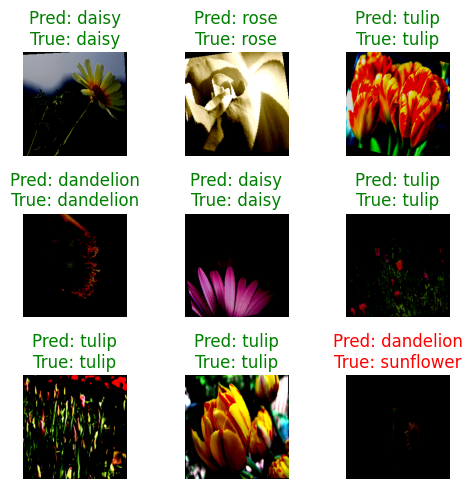

In [20]:
import matplotlib.pyplot as plt
def plot_predictions(model, dataloader, class_names, device, n=9):
    model.eval()
    X_batch, y_batch = next(iter(dataloader))
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)

    with torch.inference_mode():
        y_pred = model(X_batch)
        pred_classes = torch.argmax(y_pred, 1)

    plt.figure(figsize=(5, 5))
    for i in range(n):
        plt.subplot(3, 3, i+1)
        plt.imshow(X_batch[i].permute(1, 2, 0).cpu())
        color = 'g' if pred_classes[i] == y_batch[i] else 'r'
        plt.title(f"Pred: {class_names[pred_classes[i]]}\nTrue: {class_names[y_batch[i]]}", c=color)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

plot_predictions(model, test_dataloader, class_names, device)

## Making a confusion matrix for further prediction evaluation

In [21]:
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
except:
    !pip install -q torchmetrics -U mlxtend # for installing mlxtend upgraded version
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 18.2 MB/s eta 0:00:00
mlxtend version: 0.23.4


In [22]:
# Get predictions
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    X, y = X.to(device), y.to(device)
    y_logit = model(X)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions: 100%|██████████| 27/27 [00:05<00:00,  4.72it/s]


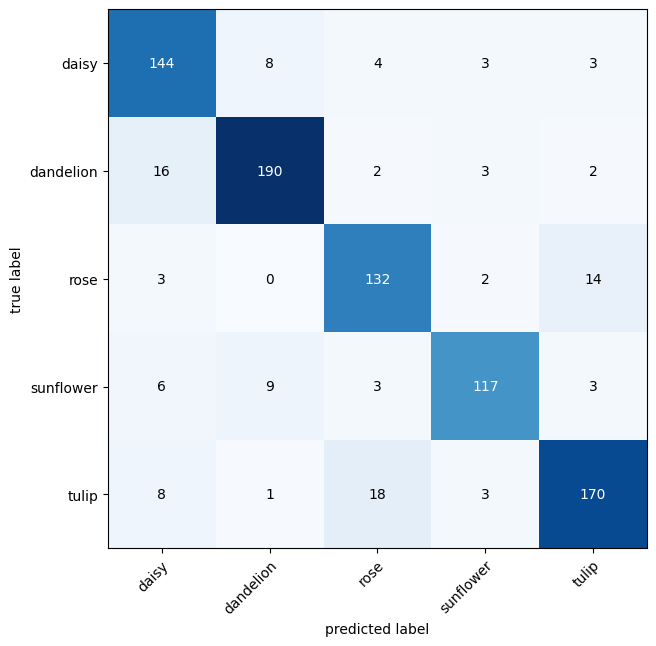

In [26]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=torch.tensor([label for _, label in test_dataset]))

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

#Doneeeeeeeeeeeeeeeeeeeeeeee🔥🔥🔥🔥🔥🚀🚀🚀🚀🚀🚀🚀🚀
